In [ ]:
from gensim.models import Word2Vec, FastText
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터 불러오기

In [ ]:
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = news_data.data     # 문서 내용
labels = news_data.target  # 레이블

In [ ]:
print(f"Number of documents: {len(texts)}")
print(f"Sample document: \n{texts[0]}")
print(f"Unique labels: {set(labels)}")

Number of documents: 18846
Sample document: 


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [ ]:
# 데이터 분할
train_inputs, test_inputs, train_targets, test_targets = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
import re
nltk.download('stopwords')
stop_words = stopwords.words('english')

# 텍스트 데이터 전처리
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# 데이터에 적용 (1)
train_inputs = [clean_text(text) for text in train_inputs]
test_inputs = [clean_text(text) for text in test_inputs]

# 단어 토큰화만 진행 (2)
# train_sentences = [word_tokenize(text) for text in train_inputs]
# test_sentences = [word_tokenize(text) for text in test_inputs]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


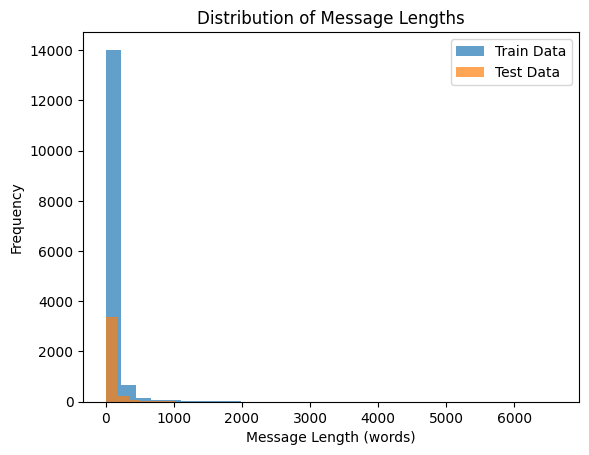

In [ ]:
# 메시지 길이 계산
train_lengths = [len(word_tokenize(msg)) for msg in train_inputs]
test_lengths = [len(word_tokenize(msg)) for msg in test_inputs]

# 히스토그램 시각화
plt.hist(train_lengths, bins=30, alpha=0.7, label='Train Data')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test Data')
plt.xlabel('Message Length (words)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()

In [ ]:
# 평균, 최대값, 중간값 계산 및 출력
print("훈련 데이터 평균 길이:", np.mean(train_lengths))
print("훈련 데이터 최대 길이:", np.max(train_lengths))
print("훈련 데이터 95분위수 길이:", np.percentile(train_lengths, 95))

훈련 데이터 평균 길이: 93.84551605200318
훈련 데이터 최대 길이: 6620
훈련 데이터 95분위수 길이: 281.25


# Word2vec

In [ ]:
# 단어 토큰화
train_sentences = [word_tokenize(text) for text in train_inputs]
test_sentences = [word_tokenize(text) for text in test_inputs]

In [ ]:
# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=128, window=5, min_count=1, sg=1)
word2vec_matrix = np.zeros((len(word2vec_model.wv) + 1, 128))
word2idx_word2vec = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

for word, idx in word2idx_word2vec.items():
    word2vec_matrix[idx] = word2vec_model.wv[word]

In [ ]:
class TextEmbeddingDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.texts[idx])
        encoded = [self.word2idx.get(word, 0) for word in tokens]  # OOV 단어는 0
        if len(encoded) < self.max_len:
            encoded += [0] * (self.max_len - len(encoded))
        else:
            encoded = encoded[:self.max_len]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [ ]:
max_len = 280

# Word2Vec Dataset
train_dataset_word2vec = TextEmbeddingDataset(train_inputs, train_targets, word2idx_word2vec, max_len)
test_dataset_word2vec = TextEmbeddingDataset(test_inputs, test_targets, word2idx_word2vec, max_len)

# Word2Vec DataLoader
train_loader_word2vec = DataLoader(train_dataset_word2vec, batch_size=64, shuffle=True)
test_loader_word2vec = DataLoader(test_dataset_word2vec, batch_size=64, shuffle=False)

In [ ]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)  # 출력: (batch_size, 20)
        loss = criterion(outputs, labels)  # 레이블은 정수형 (0~19)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            predictions = torch.argmax(outputs, dim=1)  # 가장 높은 확률의 인덱스
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
class EmbeddingLSTM(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(EmbeddingLSTM, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float).to(device), freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

In [ ]:
hidden_dim = 128
output_dim = len(set(labels))

In [ ]:
model_word2vec = EmbeddingLSTM(word2vec_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_word2vec.parameters(), lr=0.005)

for epoch in range(10):
    loss = train(model_word2vec, train_loader_word2vec, loss_fn, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

accuracy = evaluate(model_word2vec, test_loader_word2vec)
print(f"Test Accuracy (Word2Vec with LSTM): {accuracy:.4f}")

Epoch 1, Loss: 2.0305
Epoch 2, Loss: 1.1694
Epoch 3, Loss: 0.6997
Epoch 4, Loss: 0.4496
Epoch 5, Loss: 0.2950
Epoch 6, Loss: 0.2188
Epoch 7, Loss: 0.1697
Epoch 8, Loss: 0.1457
Epoch 9, Loss: 0.1318
Epoch 10, Loss: 0.1233
Test Accuracy (Word2Vec with LSTM): 0.6586


# FastText

In [ ]:
# FastText 모델 학습
fasttext_model = FastText(sentences=train_sentences, vector_size=128, window=5, min_count=1, sg=1)
fasttext_matrix = np.zeros((len(fasttext_model.wv) + 1, 128))

word2idx_fasttext = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)}

for word, idx in word2idx_fasttext.items():
    fasttext_matrix[idx] = fasttext_model.wv[word]

In [ ]:
# FastText Dataset
train_dataset_fasttext = TextEmbeddingDataset(train_inputs, train_targets, word2idx_fasttext, max_len)
test_dataset_fasttext = TextEmbeddingDataset(test_inputs, test_targets, word2idx_fasttext, max_len)

# FastText DataLoader
train_loader_fasttext = DataLoader(train_dataset_fasttext, batch_size=64, shuffle=True)
test_loader_fasttext = DataLoader(test_dataset_fasttext, batch_size=64, shuffle=False)

In [ ]:
model_fasttext = EmbeddingLSTM(fasttext_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fasttext.parameters(), lr=0.005)

for epoch in range(10):
    loss = train(model_fasttext, train_loader_fasttext, loss_fn, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

accuracy = evaluate(model_fasttext, test_loader_fasttext)
print(f"Test Accuracy (FastText with LSTM): {accuracy:.4f}")

Epoch 1, Loss: 1.9967
Epoch 2, Loss: 1.1477
Epoch 3, Loss: 0.7490
Epoch 4, Loss: 0.4946
Epoch 5, Loss: 0.3448
Epoch 6, Loss: 0.2607
Epoch 7, Loss: 0.2012
Epoch 8, Loss: 0.1671
Epoch 9, Loss: 0.1488
Epoch 10, Loss: 0.1382
Test Accuracy (FastText with LSTM): 0.6650


# GloVe

In [ ]:
import os
import urllib.request

# GloVe 다운로드 및 임베딩 로드
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_FILE = "glove.6B.200d.txt"

if not os.path.exists(GLOVE_FILE):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    import zipfile
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall()
    print("GloVe embeddings downloaded and extracted.")
else:
    print("GloVe embeddings already available.")

GloVe embeddings downloaded and extracted.


In [ ]:
embedding_dim = 200  # GloVe 임베딩 차원 설정
glove_embeddings = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coeffs

In [ ]:
len(glove_embeddings)

400000

In [ ]:
# GloVe word2idx 생성
word2idx_glove = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
glove_matrix = np.zeros((len(word2idx_glove) + 1, embedding_dim))

for word, idx in word2idx_glove.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        glove_matrix[idx] = embedding_vector

In [ ]:
# GloVe Dataset
train_dataset_glove = TextEmbeddingDataset(train_inputs, train_targets, word2idx_glove, max_len)
test_dataset_glove = TextEmbeddingDataset(test_inputs, test_targets, word2idx_glove, max_len)

# GloVe DataLoader
train_loader_glove = DataLoader(train_dataset_glove, batch_size=32, shuffle=True)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=32, shuffle=False)

In [ ]:
model_glove = EmbeddingLSTM(glove_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_glove.parameters(), lr=0.005)

for epoch in range(10):
    loss = train(model_glove, train_loader_glove, loss_fn, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

accuracy = evaluate(model_glove, test_loader_glove)
print(f"Test Accuracy (GloVe with LSTM): {accuracy:.4f}")

Epoch 1, Loss: 1.7441
Epoch 2, Loss: 1.0268
Epoch 3, Loss: 0.6785
Epoch 4, Loss: 0.4661
Epoch 5, Loss: 0.3448
Epoch 6, Loss: 0.2650
Epoch 7, Loss: 0.2335
Epoch 8, Loss: 0.2107
Epoch 9, Loss: 0.1839
Epoch 10, Loss: 0.1875
Test Accuracy (GloVe with LSTM): 0.6626
